In [5]:
from datasets import load_dataset, Features, Value

# Define the expected schema explicitly
features = Features({
    'YoutubeID': Value('string'),
    'audio': Value('string'),
    'visual': Value('string'),
    'speech': Value('string'),
    'av_caption': Value('string'),
    'avs': Value('string'),
    'fps': Value('float64'),
    'start_frame': Value('int64'),
    'end_frame': Value('int64')
})

# Load the dataset with defined features
dataset_full = load_dataset("OpenGVLab/InternVideo2_Vid_Text", features=features)


Found cached dataset json (/Users/zhuzengliang/.cache/huggingface/datasets/OpenGVLab___json/OpenGVLab--InternVideo2_Vid_Text-9937fffaa45d0f51/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
dataset_full.keys()

dict_keys(['train'])

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import random

# Define the size of the sample
sample_size = 10000  # Adjust this based on the size of the dataset

# Get the total number of rows in the dataset
total_size = len(dataset_full['train'])
print(total_size)
# Randomly select indices for the sample
random_indices = random.sample(range(total_size), sample_size)

# Create a subset of the dataset using the selected indices
dataset = dataset_full['train'].select(random_indices)


123519338


Q1: 4.0, Median: 4.0, Q3: 47.0


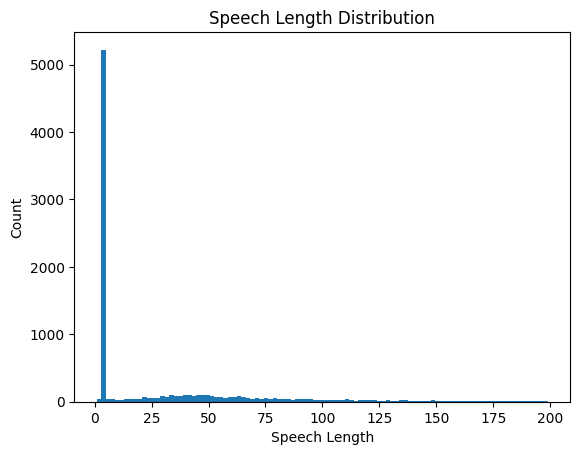

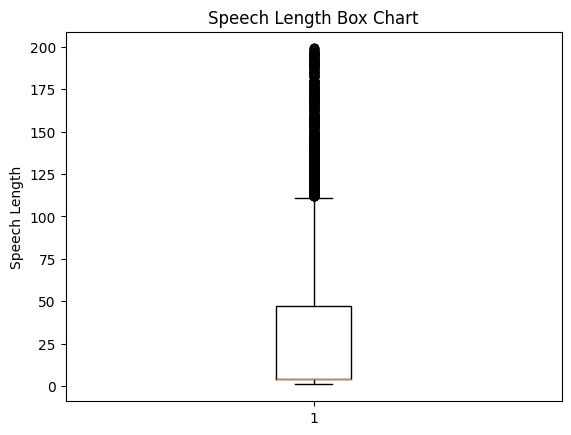

In [12]:

speech_len = dataset['speech']
speech_len = [len(str(s)) for s in speech_len]

# Convert to numpy array for processing
speech_len = np.array(speech_len)

# Filter: Remove speech length > 200 and <= 0
filtered_speech_len = speech_len[(speech_len < 200) & (speech_len > 0)]

# Calculate statistics
mean = np.mean(filtered_speech_len)
median = np.median(filtered_speech_len)
max_len = np.max(filtered_speech_len)
min_len = np.min(filtered_speech_len)
std = np.std(filtered_speech_len)



# Calculate IQR
Q1 = np.percentile(filtered_speech_len, 25)
Q3 = np.percentile(filtered_speech_len, 75)
IQR = Q3 - Q1

print(f"Q1: {Q1}, Median: {median}, Q3: {Q3}")

# Plot histogram
plt.hist(filtered_speech_len, bins=100)
plt.xlabel('Speech Length')
plt.ylabel('Count')
plt.title('Speech Length Distribution')
plt.show()

# Plot box chart
plt.boxplot(filtered_speech_len)
plt.ylabel('Speech Length')
plt.title('Speech Length Box Chart')
plt.show()


In [22]:
subtitle_none = []
subtitle_short_long = []


for entry in dataset:
    if entry['speech'] == None:
        subtitle_none.append(entry)
    else:
        subtitle_short_long.append(entry)


In [23]:
len(subtitle_none)

5133

In [24]:
len(subtitle_short_long)

4867

In [37]:
import random

# construct a sample dataset with haf of subtitle_none and subtitle_not_none
random.seed(0)
subtitle_none_sample = random.sample(subtitle_none, 20)
subtitle_short_sample = random.sample(subtitle_short_long, 100)

internVid_sample_test_120 = subtitle_none_sample + subtitle_short_sample 

In [38]:
import json 
with open('intern_vid_test120.json', 'w') as file:
    json.dump(internVid_sample_test_120, file, indent=4)

In [27]:
!pip install yt_dlp

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.41 requires requests_mock, which is not installed.
spyder 5.4.1 requires pyqt5<5.16, which is not installed.
spyder 5.4.1 requires pyqtwebengine<5.16, which is not installed.
google-api-core 2.14.0 requires google-auth<3.0.dev0,>=2.14.1, but you have google-auth 1.35.0 which is incompatible.
google-api-core 2.14.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
optimum 1.13.2 requires transformers[sentenc

In [39]:
import json
import os
import sys
import yt_dlp
import subprocess

def check_and_download(youtube_id, start_frame, end_frame, fps, output_dir, cookie_file=None):
    # Calculate start and end times in seconds
    start_time = start_frame / fps
    end_time = end_frame / fps
    video_id = youtube_id

    # Check if the trimmed video already exists
    if os.path.exists(f'{output_dir}/{video_id}.mp4'):
        print(f'Video clip {video_id} already exists.')
        return True

    youtube_url = f'https://www.youtube.com/watch?v={youtube_id}'
    
    if cookie_file:
        ydl_opts = {
            'format': 'mp4',  
            'outtmpl': f'{output_dir}/{youtube_id}_og.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',  
            }],
            'cookiefile': cookie_file
        }
    else:
        ydl_opts = {
            'format': 'mp4',  
            'outtmpl': f'{output_dir}/{youtube_id}_og.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',  
            }]
        }

    try:
        # Download the video
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([youtube_url])
        
        if not os.path.exists(f'{output_dir}/{youtube_id}_og.mp4'):
            print(f'Video {video_id} is not mp4')
            return False
        
        input_file = f'{output_dir}/{youtube_id}_og.mp4'
        output_file = f'{output_dir}/{video_id}.mp4'
        duration = end_time - start_time

        # Trim the video using ffmpeg
        subprocess.run([
            'ffmpeg', '-ss', str(start_time), '-i', input_file, '-t', str(duration), '-c', 'copy', output_file
        ], check=True)

        print(f'Video {output_file} downloaded and trimmed successfully.')
        os.remove(input_file) # delete the original video, only keep the trimmed one
        return True
    except Exception as e:
        print(f'Video {video_id} fails downloading: {e}')
        return False

def main(json_file, output_dir, cookie_file=None):
    with open(json_file) as file:
        sample_data = json.load(file)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print('>>>>> Start downloading video clips <<<<<')
    for video in sample_data:
        check_and_download(
            video['YoutubeID'], 
            video['start_frame'], 
            video['end_frame'], 
            video['fps'], 
            output_dir, 
            cookie_file
        )
    print('>>>>> Finish downloading video clips <<<<<')

        



In [ ]:

json_file = "/Users/zhuzengliang/Documents/GitHub/VividScribe/data/internVid2/intern_vid_test120.json"
output_dir = "/Users/zhuzengliang/Documents/GitHub/VividScribe/data/internVid2/raw_video"
cookie_file = "/Users/zhuzengliang/Downloads/www.youtube.com_cookies.txt"

main(json_file, output_dir, cookie_file)

## VAST dataset

In [1]:
!pip install ijson


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import ijson
import random

file_path = '/Users/zhuzengliang/Downloads/annotations.json'
sample_size = 10000
reservoir = []

# Open the large JSON file for incremental reading
with open(file_path, 'r') as f:
    parser = ijson.items(f, 'item')  # 'item' works if your JSON is an array of objects

    for index, item in enumerate(parser):
        if index < sample_size:
            # Initially fill the reservoir with the first 'sample_size' elements
            reservoir.append(item)
        else:
            # Randomly replace elements in the reservoir with decreasing probability
            r = random.randint(0, index)
            if r < sample_size:
                reservoir[r] = item

# The 'reservoir' now contains a uniform random sample of 'sample_size' items
print(reservoir[:5])  # Print first 5 items from the sample to verify


[{'clip_id': 'axAwJXJ8WTk.48', 'clip_span': ['00:08:39.950', '00:08:52.430'], 'url': 'https://www.youtube.com/watch?v=axAwJXJ8WTk', 'vision_cap': ['two men are standing inside of a storage facility, one is fixing something.', 'a man is showing a man in how to take out something.', 'a man is showing another man how to use something by holding it.', 'two men are in the middle of working on a machine, while a woman is talking about something.', 'a man is standing and talking to another person standing next to him.'], 'audio_cap': ['someone is loading items in a warehouse.', 'someone is talking about collecting parts.', 'a construction site is being recorded.', 'someone is talking about something.', 'someone is talking about collecting parts.'], 'subtitle': 'So Im not gonna, took ownership of it at that point, I dont think that whole cost as much that trip you hook me up with some squeezing please well I just hold this heavy piece of __ since its out.', 'vast_cap': "The two men were workin

Mean: 116.34922010398614, Median: 115.0, Max Length: 199, Min Length: 19, Std: 41.6495236915078
Q1: 83.0, Median: 115.0, Q3: 148.75


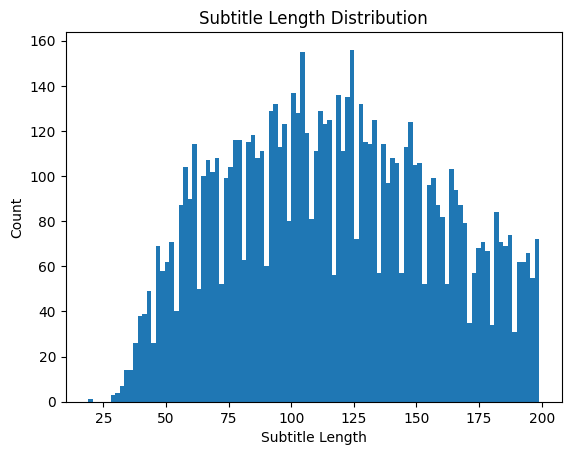

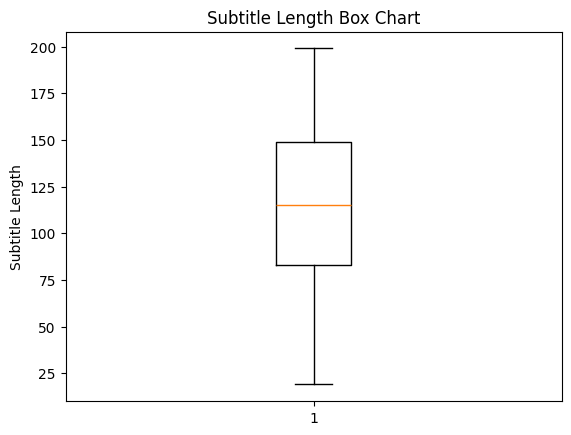

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `reservoir` contains the sampled data
# Extract the 'subtitle' field from each item in the sample
subtitle_len = [len(item['subtitle']) for item in reservoir if item['subtitle']]

# Convert to numpy array for processing
subtitle_len = np.array(subtitle_len)

# Filter: Remove subtitle length > 200 and <= 0
filtered_subtitle_len = subtitle_len[(subtitle_len < 200) & (subtitle_len > 0)]

# Calculate statistics
mean = np.mean(filtered_subtitle_len)
median = np.median(filtered_subtitle_len)
max_len = np.max(filtered_subtitle_len)
min_len = np.min(filtered_subtitle_len)
std = np.std(filtered_subtitle_len)

# Calculate IQR
Q1 = np.percentile(filtered_subtitle_len, 25)
Q3 = np.percentile(filtered_subtitle_len, 75)
IQR = Q3 - Q1

print(f"Mean: {mean}, Median: {median}, Max Length: {max_len}, Min Length: {min_len}, Std: {std}")
print(f"Q1: {Q1}, Median: {median}, Q3: {Q3}")

# Plot histogram
plt.hist(filtered_subtitle_len, bins=100)
plt.xlabel('Subtitle Length')
plt.ylabel('Count')
plt.title('Subtitle Length Distribution')
plt.show()

# Plot box chart
plt.boxplot(filtered_subtitle_len)
plt.ylabel('Subtitle Length')
plt.title('Subtitle Length Box Chart')
plt.show()


In [4]:
subtitle_none = []
subtitle_short_long = []

for entry in reservoir:
    # Check if the length of the 'speech' is less than 25
    if len(entry['subtitle']) < 25:
        subtitle_none.append(entry)
    else:
        subtitle_short_long.append(entry)


In [5]:
subtitle_none

[{'clip_id': 'k5HBLuM8Mdg.14',
  'clip_span': ['00:00:50.050', '00:00:56.051'],
  'url': 'https://www.youtube.com/watch?v=k5HBLuM8Mdg',
  'vision_cap': ["a man and woman are holding the teacher's box program as a screen shows a video of it.",
   'a woman is talking about a video of people that are being train.',
   'a woman and a man are shown smiling in front of a screen then an news cast appears on the screen.',
   'a news anchor gives a video of a new teacher.',
   'a news report about a teacher that is teaching.'],
  'audio_cap': ['voice over request.',
   'an announcement is being made.',
   'voice is over.',
   'freesound project is being described.',
   'someone is announcing a safety announcement.'],
  'subtitle': "&gt;&gt; IT'S HUGE.",
  'vast_cap': "A news report about a teacher teaching is being described, and it's huge."}]

In [ ]:
# The result shows that all videos has human voice (because subtitle is not short)

In [6]:
import random

# Randomly sample 120 items from the reservoir
sampled_items = random.sample(reservoir, 120)

# Print the first few sampled items to verify
print(sampled_items[:5])


[{'clip_id': 'Wtll1g9i0M8.15', 'clip_span': ['00:03:00.879', '00:03:10.269'], 'url': 'https://www.youtube.com/watch?v=Wtll1g9i0M8', 'vision_cap': ['the boy is winking', 'a boy is winking while looking at the camera', 'a man is talking to the camera while another person is laughing in the background.', 'a boy in his bedroom is winking', 'a young boy is talking about his friend who just finished his head.'], 'audio_cap': ['voice is being used in a game.', 'a woman is speaking.', 'a woman is speaking in a room with some english words added.', 'a young woman is speaking in a kitchen.', 'voice is being used in a game.'], 'subtitle': 'Didnt write the Harry Potter books, then I feel like it get rolling kind of created a loophole for herself in the Harry Potter series by making the houses match up to peoples characteristics and their creative complications.', 'vast_cap': 'A young boy is talking about his friend who just finished his head in the game, using a voice that created a loophole in th

In [9]:
import random

# Randomly sample 120 items from the reservoir
sampled_items2 = random.sample(sampled_items, 60)

# Print the first few sampled items to verify
print(sampled_items2[:5])

[{'clip_id': 'G51jyOgd6qc.5', 'clip_span': ['00:00:48.989', '00:00:56.039'], 'url': 'https://www.youtube.com/watch?v=G51jyOgd6qc', 'vision_cap': ['a man interviewing a player', 'a man is having a conversation', 'a man speaks to a press group and talks about soccer', 'a man is talking', 'the men were talking'], 'audio_cap': ['a man is talking about the price of the product.', 'people are talking at a library.', 'a man is talking about the price of the product.', 'a man is talking about the price of the product.', 'people are talking in a library.'], 'subtitle': 'The next game happens to be Shirley and its another three points on our phone. What will you demand from your players on Saturday against decide who are in the relegation zone?', 'vast_cap': 'A man is talking about the price of a product while having a conversation, and he is also asking about the demand for the players on Saturday against a team named Shirley, who are in the relegation zone.'}, {'clip_id': '8SmaUm6xOF4.41', 'cl

In [10]:
import json 
with open('vast_test60.json', 'w') as file:
    json.dump(sampled_items, file, indent=4)

In [ ]:
#download vast
import json
import os
import sys
import yt_dlp
import subprocess

def check_and_download(clip_id, clip_span, url, output_dir, cookie_file=None):
    # Parse the clip_span to get start and end times
    start_time_str, end_time_str = clip_span
    start_time = convert_time_to_seconds(start_time_str)
    end_time = convert_time_to_seconds(end_time_str)
    duration = end_time - start_time

    video_id = clip_id.split('.')[0]  # Extract YouTube ID from clip_id

    # Check if the trimmed video already exists
    if os.path.exists(f'{output_dir}/{clip_id}.mp4'):
        print(f'Video clip {clip_id} already exists.')
        return True

    youtube_url = url

    # Set up yt_dlp options
    if cookie_file:
        ydl_opts = {
            'format': 'mp4',
            'outtmpl': f'{output_dir}/{video_id}_og.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',
            }],
            'cookiefile': cookie_file
        }
    else:
        ydl_opts = {
            'format': 'mp4',
            'outtmpl': f'{output_dir}/{video_id}_og.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',
            }]
        }

    try:
        # Download the video
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([youtube_url])

        if not os.path.exists(f'{output_dir}/{video_id}_og.mp4'):
            print(f'Video {clip_id} is not mp4')
            return False

        input_file = f'{output_dir}/{video_id}_og.mp4'
        output_file = f'{output_dir}/{clip_id}.mp4'

        # Trim the video using ffmpeg
        subprocess.run([
            'ffmpeg', '-ss', str(start_time), '-i', input_file, '-t', str(duration), '-c', 'copy', output_file
        ], check=True)

        print(f'Video {output_file} downloaded and trimmed successfully.')
        os.remove(input_file)  # delete the original video, only keep the trimmed one
        return True
    except Exception as e:
        print(f'Video {clip_id} fails downloading: {e}')
        return False

def convert_time_to_seconds(time_str):
    """Convert a time string (hh:mm:ss.xxx) to seconds."""
    hours, minutes, seconds = time_str.split(':')
    return int(hours) * 3600 + int(minutes) * 60 + float(seconds)

def main(json_file, output_dir, cookie_file=None):
    with open(json_file) as file:
        sample_data = json.load(file)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print('>>>>> Start downloading video clips <<<<<')
    for video in sample_data:
        check_and_download(
            video['clip_id'], 
            video['clip_span'], 
            video['url'], 
            output_dir, 
            cookie_file
        )
    print('>>>>> Finish downloading video clips <<<<<')




json_file = "/Users/zhuzengliang/Documents/GitHub/VividScribe/data/vast/vast_test120.json"
output_dir = "/Users/zhuzengliang/Documents/GitHub/VividScribe/data/vast/raw_video"
cookie_file = "/Users/zhuzengliang/Downloads/www.youtube.com_cookies.txt"

main(json_file, output_dir, cookie_file)